# Exploring Security Practices in Infrastructure as Code: An Empirical Study of Azure Terraform Configurations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.dpi'] = 300

In [2]:
RESULTS_FILE = "./csv/azure_results.csv"
POLICIES_FILE = "./csv/azure_policies.csv"
DATASET = "./csv/azure_dataset_filtered.csv"
METRICS_FILE = "./csv/azure_dataset_metrics.csv"

Retrieve the list of the 121 selected policies and their mapped categories.
We also print the policies list to use in the checkov_looper.py Python script.

In [3]:
categories = {}
policies = {}
p_names = {}
with open(POLICIES_FILE, 'r') as f:
    f.readline()
    policies_rows = f.readlines()
    for row in policies_rows:
        s_row = row.split(',')
        if s_row[5] == "TRUE":
            policy_id = s_row[1]
            policy_name = s_row[3]
            policy_description = s_row[4]
            policy_category = s_row[6].strip('\n')
            if policy_category == "":
                policy_category = "Uncategorized"

            policies[policy_id] = policy_description
            categories[policy_id] = policy_category
            p_names[policy_id] = policy_name

In [4]:
print("CHECK_LIST = " + ",".join(policies))

CHECK_LIST = CKV_AZURE_1,CKV_AZURE_9,CKV_AZURE_10,CKV_AZURE_34,CKV_AZURE_48,CKV_AZURE_49,CKV_AZURE_53,CKV_AZURE_59,CKV_AZURE_68,CKV_AZURE_77,CKV_AZURE_89,CKV_AZURE_101,CKV_AZURE_104,CKV_AZURE_106,CKV_AZURE_108,CKV_AZURE_113,CKV_AZURE_120,CKV_AZURE_121,CKV_AZURE_124,CKV_AZURE_139,CKV_AZURE_160,CKV_AZURE_162,CKV_AZURE_204,CKV2_AZURE_6,CKV2_AZURE_8,CKV_AZURE_137,CKV_AZURE_141,CKV_AZURE_2,CKV_AZURE_73,CKV_AZURE_74,CKV_AZURE_93,CKV_AZURE_96,CKV_AZURE_97,CKV_AZURE_105,CKV_AZURE_117,CKV_AZURE_130,CKV_AZURE_151,CKV2_AZURE_1,CKV2_AZURE_14,CKV2_AZURE_15,CKV2_AZURE_16,CKV2_AZURE_17,CKV2_AZURE_18,CKV_AZURE_3,CKV_AZURE_14,CKV_AZURE_28,CKV_AZURE_29,CKV_AZURE_47,CKV_AZURE_70,CKV_AZURE_153,CKV_AZURE_161,CKV_AZURE_178,CKV_AZURE_197,CKV_AZURE_198,CKV_AZURE_45,CKV_AZURE_11,CKV_AZURE_118,CKV_AZURE_119,CKV_AZURE_143,CKV_AZURE_4,CKV_AZURE_30,CKV_AZURE_31,CKV_AZURE_33,CKV_AZURE_146,CKV_AZURE_156,CKV_AZURE_159,CKV2_AZURE_20,CKV2_AZURE_21,CKV_AZURE_15,CKV_AZURE_18,CKV_AZURE_44,CKV_AZURE_52,CKV_AZURE_54,CKV_AZU

## RQ1: Category Mapping Distribution

In [5]:
categories_count = {}
for policy in policies:
    categories_count[categories.get(policy, "Uncategorized")] = categories_count.get(categories.get(policy, "Uncategorized"), 0) + 1

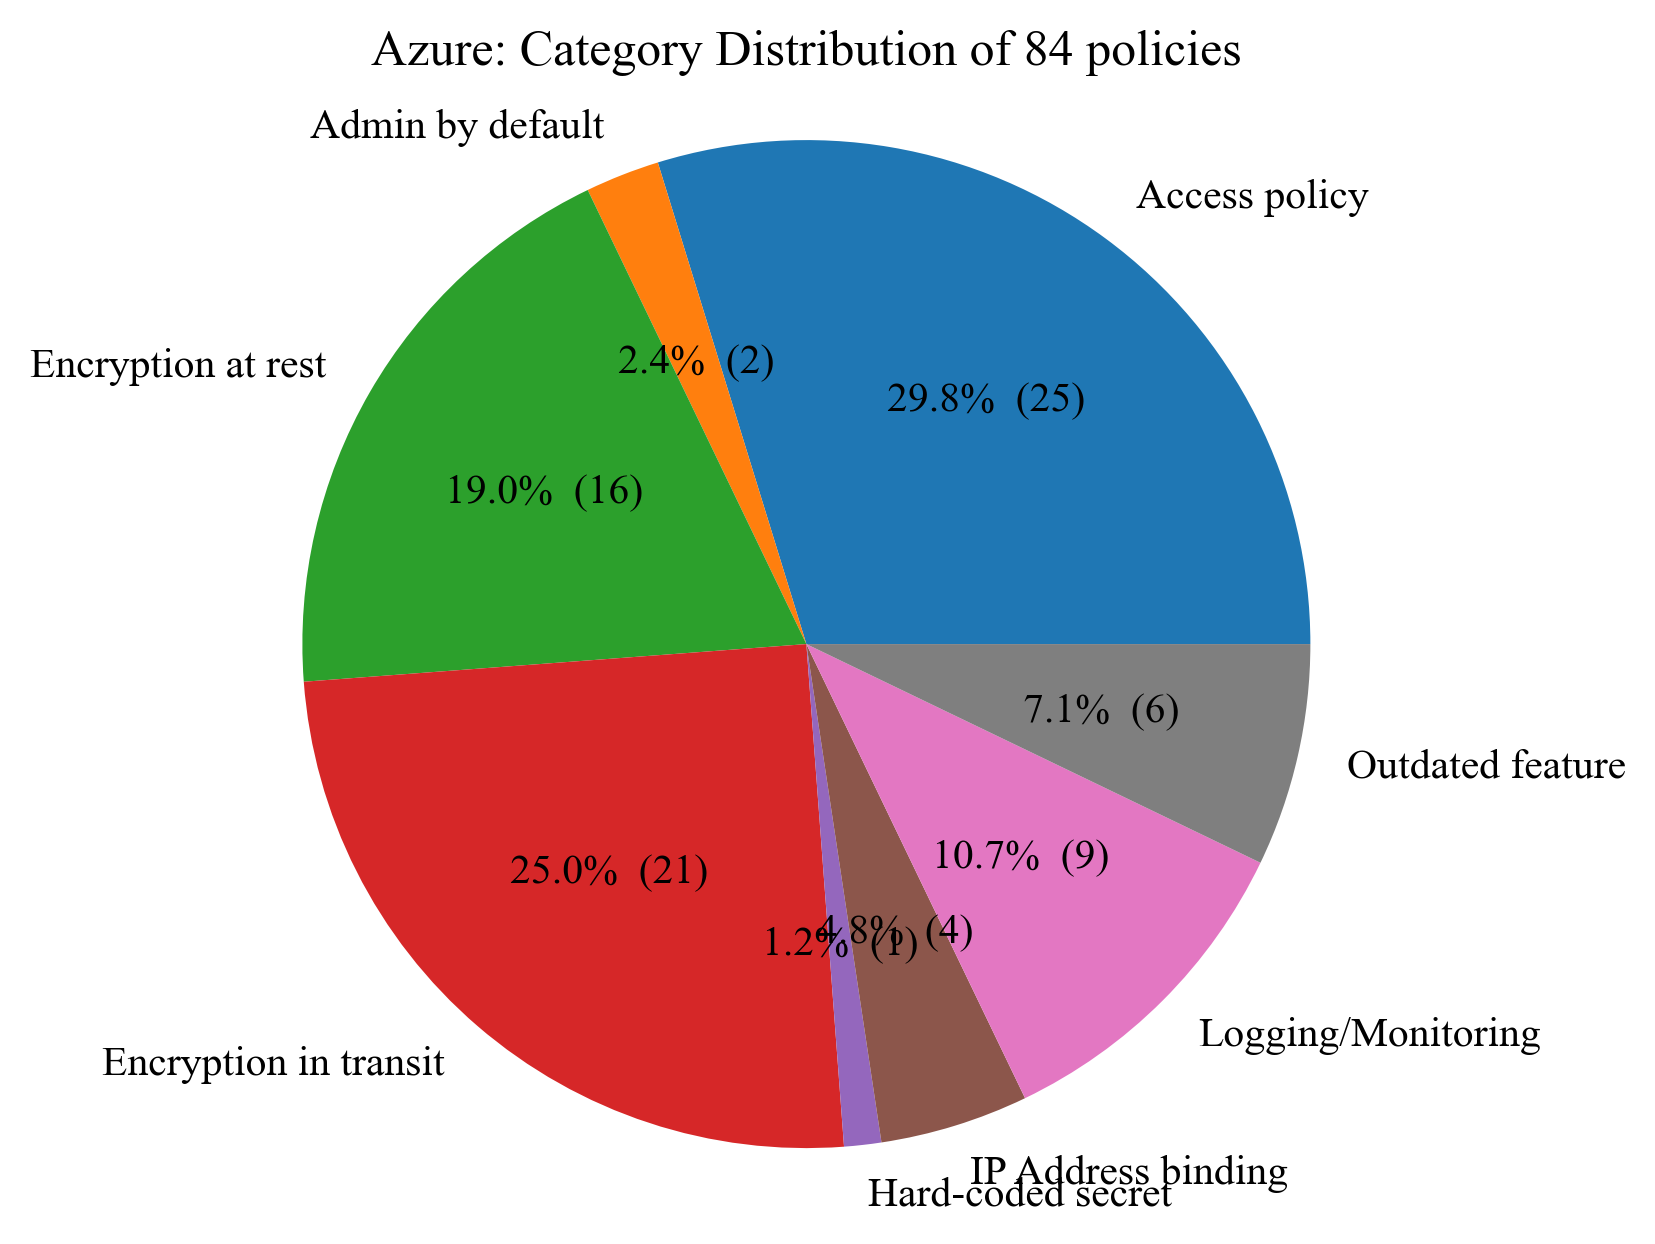

In [6]:
labels2 = sorted([*categories_count.keys()])
sizes2 = [categories_count[k] for k in labels2]
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, labels=labels2, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(sizes2)/100))
ax2.axis('equal')
ax2.set(title="Azure: Category Distribution of {} policies".format(len(policies)))
plt.show()

## Results analysis

Load the repository list of our dataset and the checkov results

In [7]:
with open(DATASET, 'r') as f:
    f.readline()
    tmp_repo_names = f.readlines()
repo_names = [k.strip("\n") for k in tmp_repo_names]

In [ ]:
with open(RESULTS_FILE, 'r') as f:
    f.readline()
    repo_results = f.readlines()

Aggregate the results per category. Ensures all policies in the results are categorized (have been selected and mapped to a category).

In [ ]:
passed_count_dict = {}
failed_count_dict = {}
categories_passed_counts = {}
categories_failed_counts = {}
uncategorized_policies = {}
repo_results_list = []
for row in repo_results:
    columns = row.split(',')
    repo_name = columns[0]
    if repo_name in repo_names:
        passed_policies = columns[3].split(';')
        failed_policies = columns[4].split(';')
        repo_results_list.append([len(passed_policies), len(failed_policies)])

        for policy in passed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_passed_counts[categories.get(policy, "Uncategorized")] = categories_passed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                passed_count_dict[policy] = passed_count_dict.get(policy, 0) + 1
                
        for policy in failed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_failed_counts[categories.get(policy, "Uncategorized")] = categories_failed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                failed_count_dict[policy] = failed_count_dict.get(policy, 0) + 1
                

total_count = {}
for policy in passed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + passed_count_dict[policy]
for policy in failed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + failed_count_dict[policy]
                    
print("Uncategorized policies: {}".format([*uncategorized_policies.keys()]))
print("Total number of passed policies: {}".format(sum(passed_count_dict.values())))
print("Total number of failed policies: {}".format(sum(failed_count_dict.values())))
print("Median number of checks per policy: {}".format(np.median([*total_count.values()])))
print("Average number of checks per policy: {}".format(np.average([*total_count.values()])))
print("Skewness of checks per policy: {}".format((np.average([*total_count.values()])-np.median([*total_count.values()]))/np.std([*total_count.values()])))

In [ ]:
nb_of_checks = []
for i in repo_results_list:
    nb_of_checks.append(i[0]+i[1])
rate_list = []
for i in repo_results_list:
    rate_list.append(100*i[0]/(i[0]+i[1]))
    
print("Median number of checks per repo: {}".format(np.median(nb_of_checks)))
print("Average number of checks per repo: {}".format(np.average(nb_of_checks)))
print("Skewness of checks per repo: {}".format((np.average(nb_of_checks)-np.median(nb_of_checks))/np.std(nb_of_checks)))
print("\n")
print("Median pass rate per repo: {}".format(np.median(rate_list)))
print("Average pass rate per repo: {}".format(np.average(rate_list)))

### Generate the Paper Full Table with the results

In [ ]:
inv_cat = {}
for k, v in categories.items():
    inv_cat[v] = inv_cat.get(v, []) + [k]
tp = ""
for cat in inv_cat:
    p = inv_cat[cat]
    tp = tp + "\multirow{" + str(len(p)) + "}{*}{" + cat + "}"
    for i in p:
        if total_count.get(i,0) != 0:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " + str(passed_count_dict.get(i,0)/total_count.get(i,0)*100)[:5] +"\\\\ \n"
        else:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " +"\\\\ \n"
    tp = tp + "\hline \n"
tp = tp.replace("_", "\_")
print(tp)

## RQ2/RQ3 : Category Pass/Fail Rate

In [ ]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 0:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

categories_rates = {}
for category in [*categories.values()]:
    categories_rates[category] = categories_passed_counts[category] / (categories_passed_counts[category] + categories_failed_counts.get(category, 0))

#categories_rates = {}
#for policy in policies_rate:
 #   categories_rates[categories[policy]] = categories_rates.get(categories[policy], []) + [policies_rate[policy]]
#for category in categories_rates:
 #   categories_rates[category] = np.average(categories_rates.get(category, []))
print(categories_rates)
print(categories_failed_counts)

In [ ]:
import pickle
with open('./azure_categories_rates.pkl', 'wb') as f:
    pickle.dump(categories_rates, f)

In [ ]:
fig7, ax7 = plt.subplots()
x = sorted([*categories_rates.keys()])
y1 = [100*categories_rates[k] for k in x]
y2 = [100-k for k in y1]
bc1 = ax7.bar(x, y1)
bc2 = ax7.bar(x, y2, bottom=y1)
ax7.bar_label(bc1, labels=['{0:.1f}%'.format(e) for e in y1], label_type='center')
ax7.bar_label(bc2, labels=['{0:.1f}%'.format(e) for e in y2], label_type='center')
ax7.set(xlabel="Category", ylabel="Pass / Fail Rate", title="Azure: Categories Pass Rate")
ax7.legend(["Passed", "Failed"])
plt.xticks(rotation=90)
plt.show()

## RQ2/RQ3 : Best and Worst Pass/Fail Policies

In [ ]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 50:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

print("Averate Pass/Fail Rate: {}".format(np.average([*policies_rate.values()])))
        
sorted_policies_rates = sorted(policies_rate, key=policies_rate.get, reverse=True)
print("Best 5 Pass / Fail Rate Policies")
for policy in sorted_policies_rates[:6]:
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))
print("Worst 5 Pass / Fail Rate Policies")
for policy in reversed(sorted_policies_rates[-7:]):
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))

Print Average number of test per category

In [ ]:
policies_nb_runs = {}
for policy in policies:
    policies_nb_runs[policy] = passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)
mean_category_runs = {}
for policy in policies_nb_runs:
    mean_category_runs[categories.get(policy, "Uncategorized")] = mean_category_runs.get(categories.get(policy, "Uncategorized"), []) + [policies_nb_runs[policy]]

for category in mean_category_runs:
    print(str(category) +" "+ str(np.sum(mean_category_runs[category])))
    mean_category_runs[category] = np.average(mean_category_runs[category])
print(mean_category_runs)

In [ ]:
stars = []
forks = []
contrib = []
with open(METRICS_FILE, 'r') as f:
    #f.readline()
    rows = f.readlines()
    for item in rows:
        column = item.split(',')
        if column[0] in repo_names:
            stars.append(int(column[1]))
            forks.append(int(column[2]))
            contrib.append(int(column[3].strip("\n")))

In [ ]:
print("Average stars: {}".format(np.average(stars)))
print("Median stars: {}".format(np.median(stars)))
print("Average forks: {}".format(np.average(forks)))
print("Median forks: {}".format(np.median(forks)))
print("Average conrtib: {}".format(np.average(contrib)))
print("Median contrib: {}".format(np.median(contrib)))